# Shopify App Store Capstone Project
7.17.22

## Objectives

This notebook will be used to gather and organize data for my Shopify App Store Capstone Project

## 1. Sourcing and Loading & Cleaning Data
Data sources:
    https://www.kaggle.com/datasets/usernam3/shopify-app-store

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import lightgbm

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


pd.options.display.max_columns = None
#pd.options.display.max_rows = None


In [2]:
# Location of invididual CSV files being used
csv_dict = {
    'apps':"/Users/msmith/Shopify_Analysis_Capstone/data/raw/apps.csv",
    'apps_categories':"/Users/msmith/Shopify_Analysis_Capstone/data/raw/apps_categories.csv",
    'categories':"/Users/msmith/Shopify_Analysis_Capstone/data/raw/categories.csv",
    'reviews':"/Users/msmith/Shopify_Analysis_Capstone/data/raw/reviews.csv"
    }

# Reading each file into a dataframe & storing in a dictionary
df_dict = {}

for k, v in csv_dict.items():
    df = pd.read_csv(v)
    df_dict[k] = df

df_dict_keys = list(df_dict.keys())
print(df_dict_keys)

['apps', 'apps_categories', 'categories', 'reviews']


In [3]:
#looping through csv summary info
for index, (k, v) in enumerate(df_dict.items()):
    print("DataFrame " + str(index + 1) + " of " + str(len(df_dict_keys)) + ": " + k)
    print(v.shape)
    print(v.columns)
    print(v.index)
    print(v.isnull().sum())
    print(v.dtypes)
    print("----------------------------")


DataFrame 1 of 4: apps
(4750, 12)
Index(['id', 'url', 'title', 'developer', 'developer_link', 'icon', 'rating',
       'reviews_count', 'description_raw', 'description', 'tagline',
       'pricing_hint'],
      dtype='object')
RangeIndex(start=0, stop=4750, step=1)
id                    0
url                   0
title                 0
developer             0
developer_link        0
icon                  0
rating                0
reviews_count         0
description_raw       0
description           0
tagline               0
pricing_hint       1980
dtype: int64
id                  object
url                 object
title               object
developer           object
developer_link      object
icon                object
rating             float64
reviews_count        int64
description_raw     object
description         object
tagline             object
pricing_hint        object
dtype: object
----------------------------
DataFrame 2 of 4: apps_categories
(7376, 2)
Index(['app_id', 'cate

In [4]:
#Unpacking dictionary into separate dataframes
apps_df = df_dict['apps']
apps_categories_df = df_dict['apps_categories']
categories_df = df_dict['categories']
reviews_df = df_dict['reviews']

#subset reviews_df for faster processing during exploration
reviews_df = reviews_df.iloc[0:20000, :]

In [5]:
#apps_df
#renaming & dropping columns
apps_df.rename(columns={'title':'app_title', 'rating':'final_rating'}, inplace=True)
apps_df = apps_df.drop(columns=(['url', 'developer_link', 'icon', 'description_raw', 'pricing_hint']))
print(apps_df.shape)
apps_df.head(2)

(4750, 7)


,id,app_title,developer,final_rating,reviews_count,description,tagline
0,9e4748a9-7eda-4814-83b6-0537d44152b1,Panda Language Translate,Panda Apps,4.7,379,Panda Language Translation improve your busine...,Translate your store into multiple languages
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,Instant Brand Page,Low Fruit Solutions PTY LTD,4.9,13,Having a brand page gives your shoppers a quic...,A-Z Brand Index Page and Favourites Slider


In [6]:
#apps_categories_df & categories_df
#renaming columns
apps_categories_df.rename(columns={'app_id':'id'}, inplace=True)
categories_df.rename(columns={'id':'category_id','title':'app_category'}, inplace=True)

#merging tables to reduce future redundancy
categories= apps_categories_df.merge(categories_df, how='left', on = 'category_id')
categories.drop('category_id', axis=1, inplace=True)

print(categories.shape)
categories.head()

(7376, 2)


,id,app_category
0,9e4748a9-7eda-4814-83b6-0537d44152b1,Store design
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,Store design
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,Store design
3,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,Customer support
4,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,Store design


In [7]:
#Creating dummy variables for each category & grouping by id
category_dummies = pd.get_dummies(categories, columns=['app_category'])
categories_dummied = category_dummies.groupby('id', as_index=False).agg('sum')
categories = categories_dummied
categories.head()

,id,app_category_Customer support,app_category_Finances,app_category_Finding and adding products,app_category_Inventory management,app_category_Marketing,app_category_Orders and shipping,app_category_Places to sell,app_category_Productivity,app_category_Reporting,app_category_Sales and conversion optimization,app_category_Store design,app_category_Trust and security
0,00014403-ad17-4c9b-bbcf-5adc27ba18a9,0,0,0,1,0,0,0,0,1,0,0,0
1,000270a8-af0b-4862-82df-25decbcc8d86,0,0,0,0,0,0,0,0,0,0,1,0
2,0006d5af-c461-4bdb-b32e-a4fecd00846b,0,0,0,0,0,0,0,0,0,0,1,0
3,001ce7ab-14dc-45ce-98f1-1b42b61c86c1,0,0,0,0,0,0,0,0,0,1,1,0
4,00215fb3-ff7c-4111-8f0c-8e7e2a9027fb,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
category_count = categories.iloc[:,1:].sum(axis=0).sort_values(ascending=False)
category_count = category_count.reset_index()
category_count_df = pd.DataFrame(category_count)
category_count_df = category_count_df.rename(columns=({'index':'app_category',
                                                       0:'count'
                                                      }))
                                      
category_count_df

,app_category,count
0,app_category_Store design,2087
1,app_category_Sales and conversion optimization,1294
2,app_category_Marketing,1068
3,app_category_Orders and shipping,858
4,app_category_Customer support,409
5,app_category_Reporting,350
6,app_category_Inventory management,342
7,app_category_Productivity,282
8,app_category_Finding and adding products,252
9,app_category_Finances,163


In [9]:
df = apps_df.merge(categories, how ='left')
print(df.shape)
df.head(5)

(4750, 19)


,id,app_title,developer,final_rating,reviews_count,description,tagline,app_category_Customer support,app_category_Finances,app_category_Finding and adding products,app_category_Inventory management,app_category_Marketing,app_category_Orders and shipping,app_category_Places to sell,app_category_Productivity,app_category_Reporting,app_category_Sales and conversion optimization,app_category_Store design,app_category_Trust and security
0,9e4748a9-7eda-4814-83b6-0537d44152b1,Panda Language Translate,Panda Apps,4.7,379,Panda Language Translation improve your busine...,Translate your store into multiple languages,0,0,0,0,0,0,0,0,0,0,1,0
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,Instant Brand Page,Low Fruit Solutions PTY LTD,4.9,13,Having a brand page gives your shoppers a quic...,A-Z Brand Index Page and Favourites Slider,0,0,0,0,0,0,0,0,0,0,1,0
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,FAQ Accordion | Help Center,POWR.io,4.5,202,"Create, organize and display Frequently Asked ...","FAQ page, FAQ accordion menu for product Info ...",1,0,0,0,0,0,0,0,0,0,1,0
3,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,Promote Me | Many apps in one,MakeProSimp,4.9,18,Promote Me app is a bundle of apps that includ...,"Spin Wheel,Currency Converter,Quick ATC Button...",0,0,0,0,0,0,0,0,0,1,1,0
4,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,Instalify,Plobal Apps,0.0,0,We are trusted by hundreds of Shopify and Shop...,Supercharge Your Mobile App Installs,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
df.dtypes

id                                                 object
app_title                                          object
developer                                          object
final_rating                                      float64
reviews_count                                       int64
description                                        object
tagline                                            object
app_category_Customer support                       uint8
app_category_Finances                               uint8
app_category_Finding and adding products            uint8
app_category_Inventory management                   uint8
app_category_Marketing                              uint8
app_category_Orders and shipping                    uint8
app_category_Places to sell                         uint8
app_category_Productivity                           uint8
app_category_Reporting                              uint8
app_category_Sales and conversion optimization      uint8
app_category_S

In [11]:
#checking for missing values on df
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by=['count'], ascending = False)

print(missing)

                                                count    %
id                                                  0  0.0
app_category_Inventory management                   0  0.0
app_category_Store design                           0  0.0
app_category_Sales and conversion optimization      0  0.0
app_category_Reporting                              0  0.0
app_category_Productivity                           0  0.0
app_category_Places to sell                         0  0.0
app_category_Orders and shipping                    0  0.0
app_category_Marketing                              0  0.0
app_category_Finding and adding products            0  0.0
app_title                                           0  0.0
app_category_Finances                               0  0.0
app_category_Customer support                       0  0.0
tagline                                             0  0.0
description                                         0  0.0
reviews_count                                       0  0

In [12]:
#reviews_df
#cleaning up naming
reviews_df = reviews_df.rename(columns={'app_id':'id', 'rating': 'individual_rating'})
reviews_df["review_id"] = reviews_df.index + 1


#Reducing reviews_df to contain only apps with >100 reviews
temp_df = reviews_df.groupby('id')[['individual_rating']].count() > 100
temp_df = temp_df[temp_df['individual_rating'] == True]
temp_df = temp_df.reset_index()

#creation of reviews hundred plus dataframe
reviews_df = reviews_df.loc[reviews_df['id'].isin(temp_df['id'])].reset_index()

#updating dtypes
reviews_df['posted_at'] = pd.to_datetime(reviews_df['posted_at'])

#Subsetting to remove reviews with missing author or body
reviews_df = reviews_df.loc[reviews_df['body'].notnull() & reviews_df['author'].notnull()].copy()
print(reviews_df.shape)

#dropping unwanted columns
reviews_df = reviews_df.drop(columns=(['developer_reply', 'developer_reply_posted_at']))

print(reviews_df.dtypes)

(14416, 10)
index                         int64
id                           object
author                       object
individual_rating             int64
posted_at            datetime64[ns]
body                         object
helpful_count                 int64
review_id                     int64
dtype: object


In [13]:
#creating a recommendation column based on ratings of 4+
reviews_df['recommended'] = reviews_df['individual_rating'] >= 4
reviews_df['recommended'] = reviews_df['recommended'].astype(int)

In [14]:
reviews_df.head()

,index,id,author,individual_rating,posted_at,body,helpful_count,review_id,recommended
0,569,8ecdfea5-03a0-4ad4-b154-f00f52f42195,The Kaizen Co,3,2020-07-27,Setup: super easy for level of understanding\n...,0,570,0
1,574,8ecdfea5-03a0-4ad4-b154-f00f52f42195,StandIn Black,5,2020-07-27,Very easy to intergrate and set up!! Looking f...,0,575,1
2,575,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Paw Fluff,5,2020-07-27,Love that is free. Is is very simple and easy ...,0,576,1
3,579,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Endless Super Bargain,5,2020-07-27,I do hope it works perfect. I like the interfa...,0,580,1
4,583,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Skylish Household Goods,5,2020-07-27,"Awesome app, my entire store has so many of th...",0,584,1


In [15]:
#checking for missing values on reviews_df
missing = pd.concat([reviews_df.isnull().sum(), 100 * reviews_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by=['count'], ascending = False)

print(missing)

                   count    %
index                  0  0.0
id                     0  0.0
author                 0  0.0
individual_rating      0  0.0
posted_at              0  0.0
body                   0  0.0
helpful_count          0  0.0
review_id              0  0.0
recommended            0  0.0


In [16]:
#creating average rating series for the first 50 reviews, by increments of 10
reviews_sorted = reviews_df.sort_values(by=['posted_at'])

first_10_ratings = reviews_sorted.groupby('id').head(10)
avg_first_10_ratings = first_10_ratings.groupby('id').agg(first_10_ratings=('individual_rating', 'mean'))

first_20_ratings = reviews_sorted.groupby('id').head(20)
avg_first_20_ratings = first_20_ratings.groupby('id').agg(first_20_ratings=('individual_rating', 'mean'))

first_30_ratings = reviews_sorted.groupby('id').head(30)
avg_first_30_ratings = first_30_ratings.groupby('id').agg(first_30_ratings=('individual_rating', 'mean'))

first_40_ratings = reviews_sorted.groupby('id').head(40)
avg_first_40_ratings = first_40_ratings.groupby('id').agg(first_40_ratings=('individual_rating', 'mean'))

first_50_ratings = reviews_sorted.groupby('id').head(50)
avg_first_50_ratings = first_50_ratings.groupby('id').agg(first_50_ratings=('individual_rating', 'mean'))

final_rating = reviews_df.groupby(['id']).mean()
final_rating = final_rating[['individual_rating']]
final_rating.rename(columns={'individual_rating':'final_rating_detailed'}, inplace=True)



In [17]:
#creating an average ratings dataframe
avg_ratings_df = pd.concat([avg_first_10_ratings, avg_first_20_ratings, avg_first_30_ratings, 
                               avg_first_40_ratings,avg_first_50_ratings, final_rating], axis=1)
avg_ratings_df = avg_ratings_df.reset_index()
avg_ratings_df.dtypes


id                        object
first_10_ratings         float64
first_20_ratings         float64
first_30_ratings         float64
first_40_ratings         float64
first_50_ratings         float64
final_rating_detailed    float64
dtype: object

In [18]:
#Merging average ratings data to main df
df = df.merge(avg_ratings_df, how='inner')

In [19]:
#subset of data by app type
app_subsets_dict = {'cust_support_apps': df[df['app_category_Customer support'] == 1],
                   'finances_apps': df[df['app_category_Finances'] == 1],
                    'find_add_products_apps' : df[df['app_category_Finding and adding products'] == 1],
                    'inventory_mgmt_apps' : df[df['app_category_Inventory management'] == 1],
                    'marketing_apps' : df[df['app_category_Marketing'] == 1],
                    'orders_shipping_apps' : df[df['app_category_Orders and shipping'] == 1],
                    'places_to_sell_apps' : df[df['app_category_Places to sell'] == 1],
                    'productivity_apps' : df[df['app_category_Productivity'] == 1],
                    'reporting_apps' : df[df['app_category_Reporting'] == 1],
                    'sales_conversion_optimization_apps' : df[df['app_category_Sales and conversion optimization'] == 1],
                    'store_design_apps' : df[df['app_category_Store design'] == 1],
                    'trust_security_apps' : df[df['app_category_Trust and security'] == 1]}

## 2. Exploratory Data Analysis

Objects created in section 1 are: 
1. df = containing general app data
2. reviews_df = containing review data
3. app_subsets_dict = containing app subsets[k], and count[v]
4. category_count_df = containing a count of apps by category type

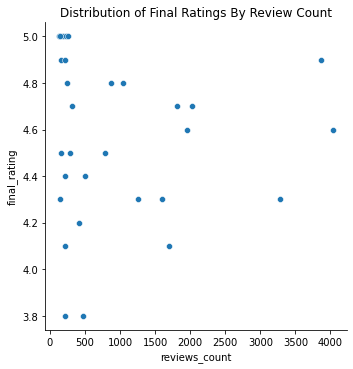

In [20]:
sns.relplot(data=df, x='reviews_count', y='final_rating')
plt.title("Distribution of Final Ratings By Review Count")
plt.show()

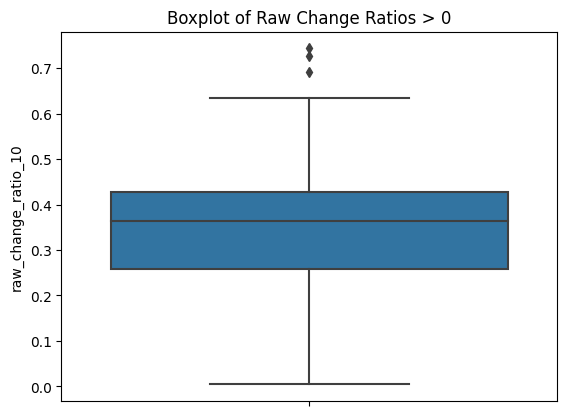

In [21]:
#Creation of a raw change value from avg of first 10 ratings vs final rating
df['raw_change_ratio_10'] = abs(df['final_rating_detailed']-df['first_10_ratings'])
changes_greater_than_0_first_10 = df[df['raw_change_ratio_10'] > 0]
sns.boxplot(data=changes_greater_than_0_first_10, 
            y="raw_change_ratio_10")
plt.title("Boxplot of Raw Change Ratios > 0")
plt.show()

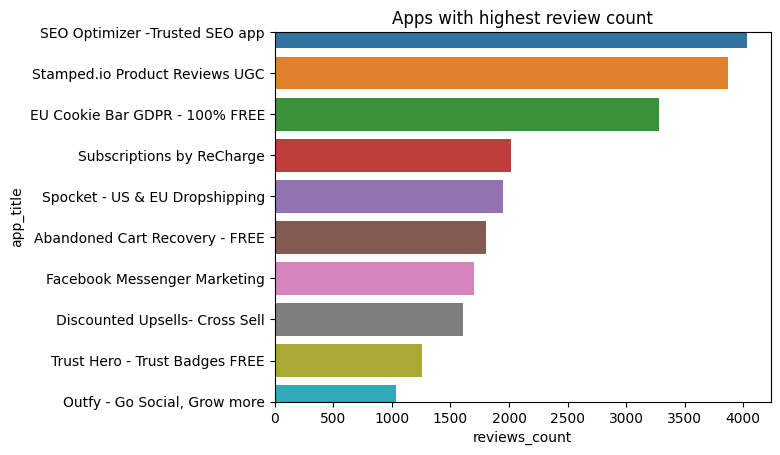

In [22]:
#Visualization of top 10 apps by review count
limit = 9
sorted_reviews = df.sort_values('reviews_count', ascending=False)
sorted_reviews.head()

sns.barplot(data=sorted_reviews, y='app_title', x='reviews_count', palette='tab10')
plt.ylim(limit, 0)
#plt.xticks(rotation=90)
plt.title('Apps with highest review count')
plt.show()

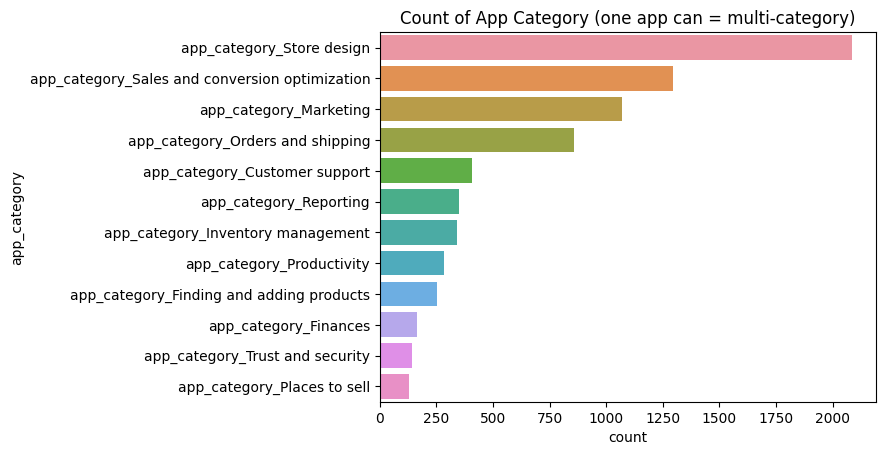

In [23]:
#Visualization of popularity of apps by raw count of categories
sns.barplot(data=category_count_df, y='app_category', x='count')
#plt.xlim(0, limit)
#plt.xticks(rotation=90)
plt.title('Count of App Category (one app can = multi-category)')
plt.show()

In [24]:
#Setup of temporary dataframe for next step
apps_and_reviews = pd.merge(reviews_df, df, how='left')
sorted_apps_and_reviews = apps_and_reviews.sort_values('reviews_count', ascending=False)

#Creation of counter for each tier (1-5) rating by category
ratings_per_category_df = pd.DataFrame({'category':category_count_df['app_category'],
'rating_1':[sorted_apps_and_reviews.loc[(sorted_apps_and_reviews[x] == 1) &
     (sorted_apps_and_reviews['individual_rating'] == 1.0)]['final_rating_detailed'].count()
     for x in category_count_df['app_category']],                              
'rating_2': [sorted_apps_and_reviews.loc[(sorted_apps_and_reviews[x] == 1) &
    (sorted_apps_and_reviews['individual_rating'] == 2.0)]['final_rating_detailed'].count()
    for x in category_count_df['app_category']],
'rating_3': [sorted_apps_and_reviews.loc[(sorted_apps_and_reviews[x] == 1) &
    (sorted_apps_and_reviews['individual_rating'] == 3.0)]['final_rating_detailed'].count()
    for x in category_count_df['app_category']],
'rating_4': [sorted_apps_and_reviews.loc[(sorted_apps_and_reviews[x] == 1) &
    (sorted_apps_and_reviews['individual_rating'] == 4.0)]['final_rating_detailed'].count()
    for x in category_count_df['app_category']],
'rating_5': [sorted_apps_and_reviews.loc[(sorted_apps_and_reviews[x] == 1) &
    (sorted_apps_and_reviews['individual_rating'] == 5.0)]['final_rating_detailed'].count()
    for x in category_count_df['app_category']]
})

ratings_per_category_df

,category,rating_1,rating_2,rating_3,rating_4,rating_5
0,app_category_Store design,279,103,320,1501,5977
1,app_category_Sales and conversion optimization,191,52,209,898,4945
2,app_category_Marketing,174,49,160,724,3305
3,app_category_Orders and shipping,48,8,10,65,809
4,app_category_Customer support,20,5,5,10,171
5,app_category_Reporting,0,0,0,0,0
6,app_category_Inventory management,0,0,0,0,0
7,app_category_Productivity,2,0,0,0,140
8,app_category_Finding and adding products,66,23,27,86,1174
9,app_category_Finances,0,0,0,0,0


In [25]:
#Set Index so apply statement in next step will work correctly
ratings_per_category_df = ratings_per_category_df.set_index('category')

#Changing total review count by category to percentage (by category)
ratings_per_category = ratings_per_category_df.iloc[:, :].T.apply(lambda x: x / x.sum(axis=0))
ratings_per_category = ratings_per_category.T.reset_index()
ratings_per_category

,category,rating_1,rating_2,rating_3,rating_4,rating_5
0,app_category_Store design,0.034108,0.012592,0.039120,0.183496,0.730685
1,app_category_Sales and conversion optimization,0.030342,0.008261,0.033201,0.142653,0.785544
2,app_category_Marketing,0.039438,0.011106,0.036265,0.164098,0.749093
3,app_category_Orders and shipping,0.051064,0.008511,0.010638,0.069149,0.860638
4,app_category_Customer support,0.094787,0.023697,0.023697,0.047393,0.810427
5,app_category_Reporting,NaN,NaN,NaN,NaN,NaN
6,app_category_Inventory management,NaN,NaN,NaN,NaN,NaN
7,app_category_Productivity,0.014085,0.000000,0.000000,0.000000,0.985915
8,app_category_Finding and adding products,0.047965,0.016715,0.019622,0.062500,0.853198
9,app_category_Finances,NaN,NaN,NaN,NaN,NaN


In [26]:
#Melting ratings dataframe for visualization
ratings_melted = pd.melt(ratings_per_category, id_vars=['category'], value_vars=['rating_1', 'rating_2','rating_3','rating_4','rating_5'],
       var_name='rating_tier', value_name='percentage')

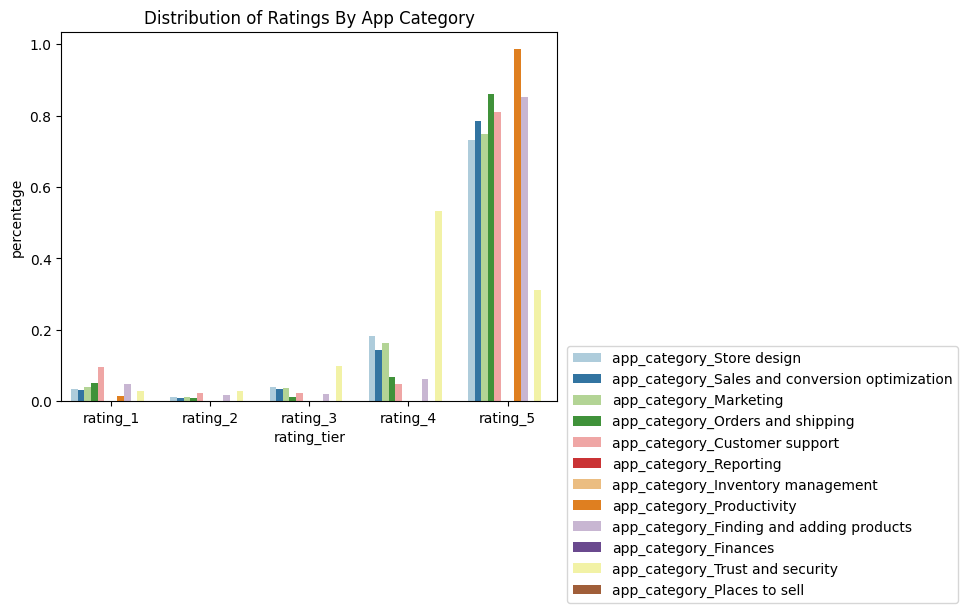

In [27]:
#Visualization of Ratings by App Category
sns.barplot(data=ratings_melted, x='rating_tier', y='percentage', 
            hue="category", palette="Paired")
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.title("Distribution of Ratings By App Category")
plt.show()

## 3. Modeling

### Text Sentiment Analysis

#### Vaders Sentiment Scoring

In [28]:
#Vaders Sentiment Scoring
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# #Bert Sentiment Scoring
# from transformers import AutoTokenizer
# from transformers import AutoModelForSequenceClassification
# from scipy.special import softmax

In [29]:
sia = SentimentIntensityAnalyzer()

In [30]:
results = {}
for i, row in tqdm(reviews_df.iterrows(), total = len(reviews_df)):
    text = row['body']
    review_id = row['review_id']
    results[review_id] = sia.polarity_scores(text)

  0%|          | 0/14416 [00:00<?, ?it/s]

In [31]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'review_id'})
vaders = vaders.merge(reviews_df, how = 'left')
vaders.head()

,review_id,neg,neu,pos,compound,index,id,author,individual_rating,posted_at,body,helpful_count,recommended
0,570,0.193,0.543,0.264,0.4287,569,8ecdfea5-03a0-4ad4-b154-f00f52f42195,The Kaizen Co,3,2020-07-27,Setup: super easy for level of understanding\n...,0,0
1,575,0.000,0.696,0.304,0.8350,574,8ecdfea5-03a0-4ad4-b154-f00f52f42195,StandIn Black,5,2020-07-27,Very easy to intergrate and set up!! Looking f...,0,1
2,576,0.000,0.622,0.378,0.8991,575,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Paw Fluff,5,2020-07-27,Love that is free. Is is very simple and easy ...,0,1
3,580,0.000,0.590,0.410,0.8957,579,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Endless Super Bargain,5,2020-07-27,I do hope it works perfect. I like the interfa...,0,1
4,584,0.000,0.665,0.335,0.9117,583,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Skylish Household Goods,5,2020-07-27,"Awesome app, my entire store has so many of th...",0,1


In [32]:
#Preview of sentiment score & metadata
vaders.head(10)

,review_id,neg,neu,pos,compound,index,id,author,individual_rating,posted_at,body,helpful_count,recommended
0,570,0.193,0.543,0.264,0.4287,569,8ecdfea5-03a0-4ad4-b154-f00f52f42195,The Kaizen Co,3,2020-07-27,Setup: super easy for level of understanding\n...,0,0
1,575,0.000,0.696,0.304,0.8350,574,8ecdfea5-03a0-4ad4-b154-f00f52f42195,StandIn Black,5,2020-07-27,Very easy to intergrate and set up!! Looking f...,0,1
2,576,0.000,0.622,0.378,0.8991,575,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Paw Fluff,5,2020-07-27,Love that is free. Is is very simple and easy ...,0,1
3,580,0.000,0.590,0.410,0.8957,579,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Endless Super Bargain,5,2020-07-27,I do hope it works perfect. I like the interfa...,0,1
4,584,0.000,0.665,0.335,0.9117,583,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Skylish Household Goods,5,2020-07-27,"Awesome app, my entire store has so many of th...",0,1
5,588,0.058,0.510,0.432,0.9052,587,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Blue Line Aquariums,5,2020-07-27,"Simple to install app, time will tell on the e...",0,1
6,589,0.000,0.550,0.450,0.9055,588,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Shop and Bag It,5,2020-07-27,This is genius. Thank you very much for a gre...,0,1
7,593,0.152,0.742,0.107,-0.2444,592,8ecdfea5-03a0-4ad4-b154-f00f52f42195,DMOE PET SUPPLIES,5,2020-07-27,This is a must have to increase sales!!! Somet...,0,1
8,594,0.000,0.286,0.714,0.9682,593,8ecdfea5-03a0-4ad4-b154-f00f52f42195,Fitbit Go,5,2020-07-27,Thank you.\nThank you.\nThank you.\nThank you....,0,1
9,598,0.072,0.629,0.298,0.8012,597,8ecdfea5-03a0-4ad4-b154-f00f52f42195,andvp,5,2020-07-27,So easy to setup and begin making money that w...,0,1


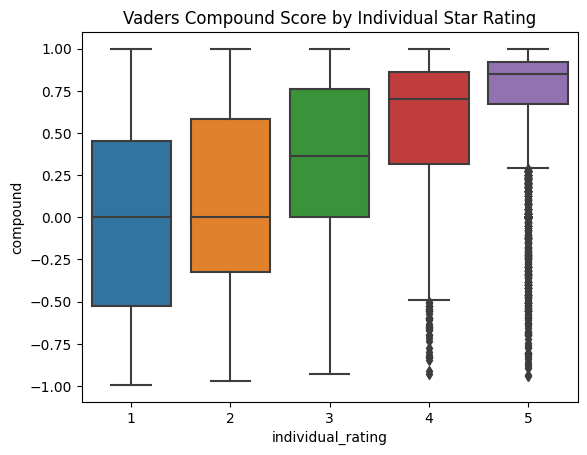

In [33]:
ax = sns.boxplot(data=vaders, x='individual_rating', y='compound')
ax.set_title('Vaders Compound Score by Individual Star Rating')
plt.show()

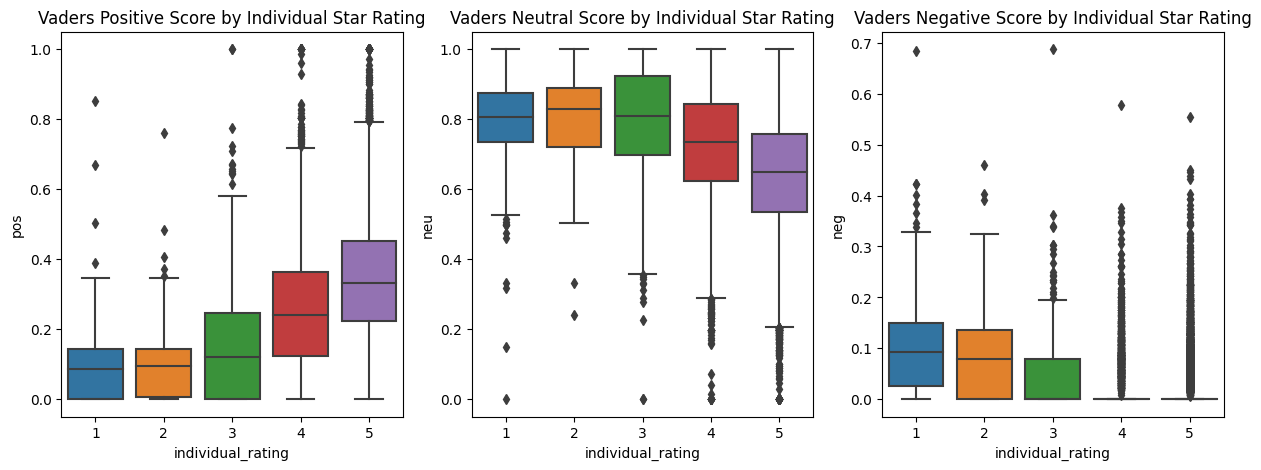

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=vaders, x='individual_rating', y='pos', ax=axs[0])
sns.boxplot(data=vaders, x='individual_rating', y='neu', ax=axs[1])
sns.boxplot(data=vaders, x='individual_rating', y='neg', ax=axs[2])
axs[0].set_title('Vaders Positive Score by Individual Star Rating')
axs[1].set_title('Vaders Neutral Score by Individual Star Rating')
axs[2].set_title('Vaders Negative Score by Individual Star Rating')
plt.show()

## Topic Modeling of General Corpus

In [35]:
# Pycaret NLP package was utilized for preprocessing.
# This does the following text cleaning
# It removes numeric&special charactes, performs tokenization,
# removes stopwords, extracts bigrams&trigrams, lemmatizes the corpus
from pycaret.nlp import *

exp_nlp101 = setup(data = reviews_df, target = 'body', session_id = 123)

Description,Value
session_id,123
Documents,14416
Vocab Size,7169
Custom Stopwords,False


In [36]:
lda=create_model('lda',num_topics=3,multi_core=True)

In [37]:
plot_model(lda, plot = 'topic_distribution')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
plot_model(plot = 'bigram')

In [39]:
plot_model(plot = 'trigram')

## Classification of General Corpus

In [40]:
# We vectorize the preprocessed corpus and put them into my_pd
vectorizer = CountVectorizer(max_features=1000)
sentences=[' '.join(i) for i in exp_nlp101[0]]
my_vec=vectorizer.fit_transform(sentences)
# my_pd is the processed dataset that represents a vectorized feature set
# and a label that indicates whether a product is recommended by the reviewer
my_pd = pd.DataFrame(my_vec.toarray())
my_pd.columns = vectorizer.get_feature_names()
my_pd['label']=reviews_df['recommended']
my_pd['sentiment_score'] = vaders['compound']
my_pd.sum().sort_values(ascending=False)

label              13118.0000
sentiment_score     9385.2789
app                 8368.0000
use                 4747.0000
great               4058.0000
                      ...    
surprised             18.0000
variation             18.0000
affect                18.0000
explanation           18.0000
tremendously          18.0000
Length: 1002, dtype: float64

In [41]:
# We put this into a pycaret classification module for training of the model
from pycaret.classification import *
exp_clf101 = setup(data = my_pd,
                   target = 'label',
                   fix_imbalance=True,
                   session_id=123)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(14416, 1002)"
5,Missing Values,True
6,Numeric Features,1
7,Categorical Features,1000
8,Ordinal Features,False
9,High Cardinality Features,False


In [42]:
# Here, we compare the performance of untuned models
compare_models(fold=4,sort='AUC',round=3,exclude=['knn','rbfsvm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.880,0.527,0.960,0.913,0.936,0.010,0.012,5.308
lightgbm,Light Gradient Boosting Machine,0.880,0.518,0.959,0.914,0.936,0.021,0.025,2.210
rf,Random Forest Classifier,0.881,0.515,0.961,0.913,0.936,0.009,0.012,3.672
ada,Ada Boost Classifier,0.787,0.513,0.846,0.914,0.879,0.015,0.015,3.338
gbc,Gradient Boosting Classifier,0.828,0.509,0.897,0.914,0.905,0.014,0.014,9.850
dt,Decision Tree Classifier,0.814,0.501,0.880,0.912,0.896,0.002,0.001,2.188
dummy,Dummy Classifier,0.088,0.500,0.000,0.000,0.000,0.000,0.000,1.122
nb,Naive Bayes,0.316,0.491,0.279,0.907,0.426,-0.005,-0.012,1.688
qda,Quadratic Discriminant Analysis,0.718,0.490,0.767,0.910,0.832,-0.011,-0.013,29.552
lda,Linear Discriminant Analysis,0.603,0.490,0.626,0.911,0.742,-0.004,-0.006,22.105


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [43]:
gbm = create_model('lightgbm')
tuned_gbm =tune_model(gbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8620,0.5536,0.9391,0.9123,0.9255,-0.0048,-0.0049
1,0.8997,0.4604,0.9826,0.9140,0.9470,0.0258,0.0346
2,0.9007,0.5494,0.9837,0.9140,0.9475,0.0444,0.0597
3,0.9056,0.4999,0.9924,0.9119,0.9504,-0.0131,-0.0259
4,0.8956,0.5215,0.9771,0.9144,0.9447,0.0334,0.0410
5,0.8907,0.4777,0.9749,0.9114,0.9421,-0.0204,-0.0253
6,0.9085,0.5934,0.9891,0.9172,0.9518,0.0909,0.1294
7,0.8976,0.5226,0.9793,0.9145,0.9458,0.0372,0.0468
8,0.8608,0.4898,0.9390,0.9112,0.9249,-0.0182,-0.0185


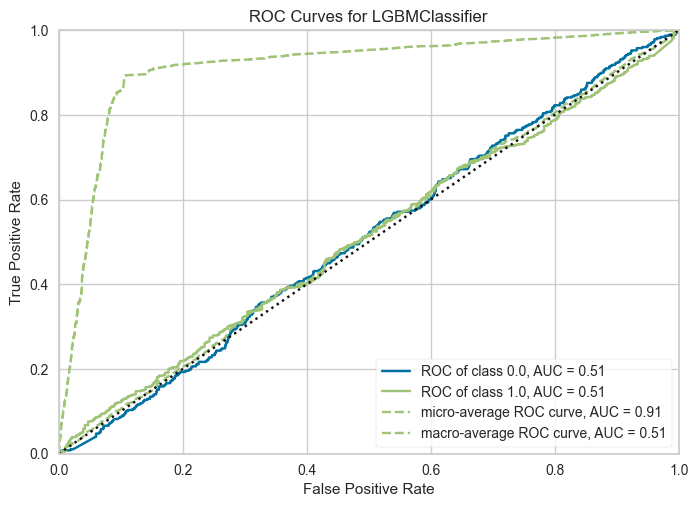

In [45]:
plot_model(tuned_gbm, plot = 'auc')

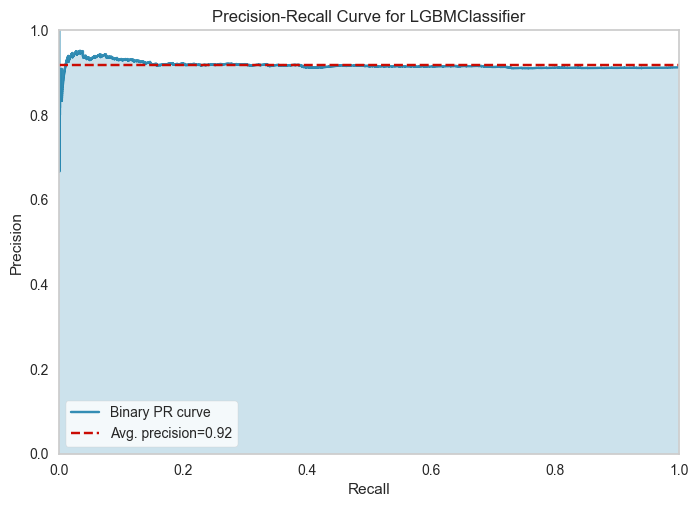

In [46]:
plot_model(tuned_gbm, plot = 'pr')

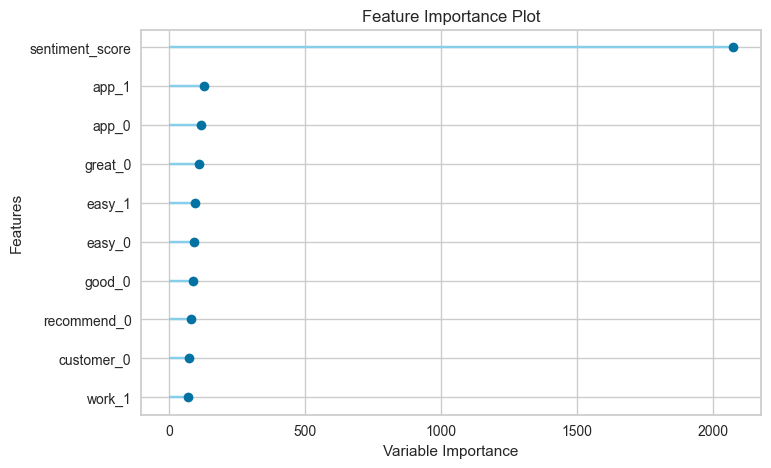

In [47]:
plot_model(tuned_gbm, plot='feature')

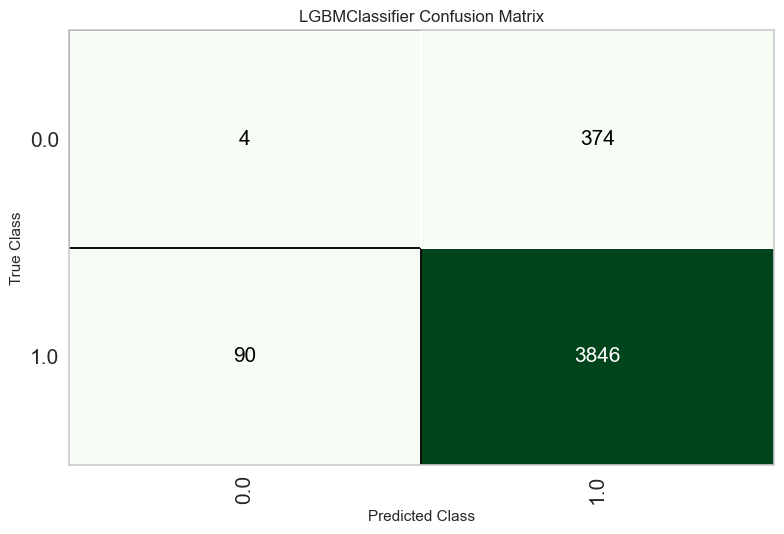

In [48]:
plot_model(tuned_gbm, plot = 'confusion_matrix')

In [49]:
#evaluate_model(lda)

## Topic Modeling of Negative (<4.0) Reviews

In [50]:
from pycaret.nlp import *

custom_stopwords=[]
exp_nlp101 = setup(data = reviews_df[reviews_df['recommended']==0],
                   target = 'body',
                   session_id = 123
                  )

Description,Value
session_id,123
Documents,1262
Vocab Size,2934
Custom Stopwords,False


In [51]:
lda=create_model('lda',num_topics=3,multi_core=True)

In [52]:
plot_model(lda, plot = 'topic_distribution')

In [53]:
plot_model(plot = 'bigram')

In [54]:
plot_model(plot = 'trigram')

## Classification of Negative (<4.0) Reviews

In [55]:
# We vectorize the preprocessed corpus and put them into my_pd
vectorizer = CountVectorizer(max_features=1000)
sentences=[' '.join(i) for i in exp_nlp101[0]]
my_vec=vectorizer.fit_transform(sentences)
# my_pd is the processed dataset that represents a vectorized feature set
# and a label that indicates whether a product is recommended by the reviewer
my_pd = pd.DataFrame(my_vec.toarray())
my_pd.columns = vectorizer.get_feature_names()
my_pd['label']=reviews_df['recommended']
my_pd['sentiment_score'] = vaders['compound']
my_pd.sum().sort_values(ascending=False)

label              954.0000
app                786.0000
sentiment_score    655.4854
work               449.0000
use                423.0000
                     ...   
viable               3.0000
visible              3.0000
shoot                3.0000
shot                 3.0000
verify               3.0000
Length: 1001, dtype: float64

In [56]:
# We put this into a pycaret classification module for training of the model
from pycaret.classification import *
exp_clf101 = setup(data = my_pd,
                   target = 'label',
                   fix_imbalance=True,
                   session_id=123)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1262, 1001)"
5,Missing Values,True
6,Numeric Features,1
7,Categorical Features,999
8,Ordinal Features,False
9,High Cardinality Features,False


In [57]:
# Here, we compare the performance of untuned models
compare_models(fold=4,sort='AUC',round=3,exclude=['knn','rbfsvm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.580,0.531,0.656,0.748,0.697,0.016,0.017,0.350
gbc,Gradient Boosting Classifier,0.637,0.529,0.781,0.742,0.760,0.008,0.009,0.695
lr,Logistic Regression,0.569,0.522,0.625,0.752,0.683,0.029,0.030,0.845
dt,Decision Tree Classifier,0.619,0.521,0.731,0.749,0.740,0.029,0.029,0.595
nb,Naive Bayes,0.565,0.519,0.613,0.755,0.676,0.031,0.034,0.360
lightgbm,Light Gradient Boosting Machine,0.655,0.517,0.826,0.740,0.780,-0.009,-0.010,0.278
rf,Random Forest Classifier,0.702,0.515,0.911,0.744,0.819,0.016,0.023,0.348
et,Extra Trees Classifier,0.700,0.510,0.898,0.748,0.816,0.036,0.041,0.408
dummy,Dummy Classifier,0.259,0.500,0.000,0.000,0.000,0.000,0.000,0.155
qda,Quadratic Discriminant Analysis,0.730,0.492,0.985,0.739,0.844,-0.022,-0.062,0.570


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)

In [64]:
gbm = create_model('lightgbm')
tuned_gbm =tune_model(gbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6742,0.4769,0.8333,0.7534,0.7914,0.0563,0.0578
1,0.5618,0.4137,0.7273,0.6957,0.7111,-0.1940,-0.1948
2,0.6932,0.5620,0.8788,0.7532,0.8112,0.0182,0.0198
3,0.6705,0.5702,0.8636,0.7403,0.7972,-0.0545,-0.0595
4,0.6477,0.5361,0.8154,0.7361,0.7737,-0.0119,-0.0122
5,0.6250,0.5532,0.8000,0.7222,0.7591,-0.0772,-0.0792
6,0.6818,0.4809,0.8769,0.7403,0.8028,0.0088,0.0098
7,0.6932,0.6294,0.8615,0.7568,0.8058,0.0904,0.0948
8,0.6477,0.5100,0.8154,0.7361,0.7737,-0.0119,-0.0122


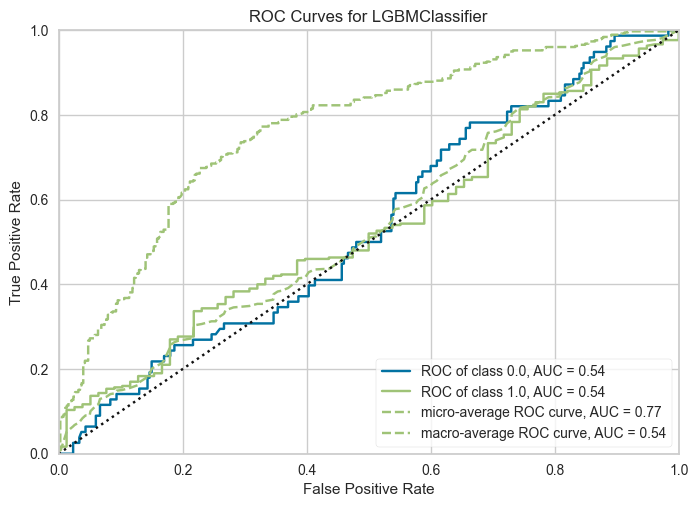

In [65]:
plot_model(tuned_gbm, plot = 'auc')

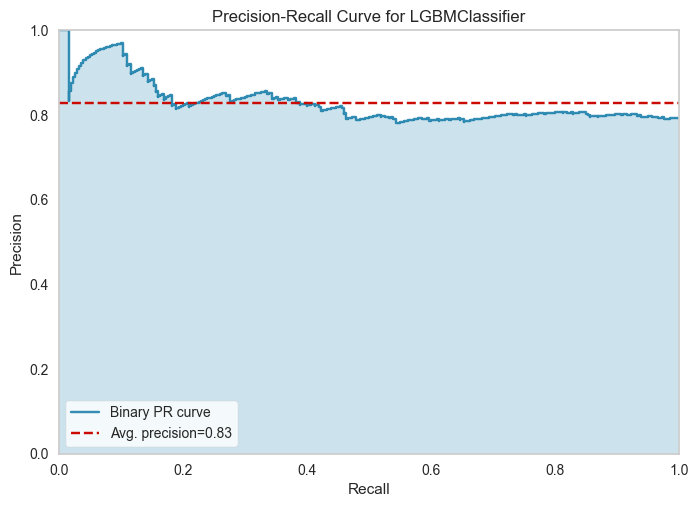

In [66]:
plot_model(tuned_gbm, plot = 'pr')

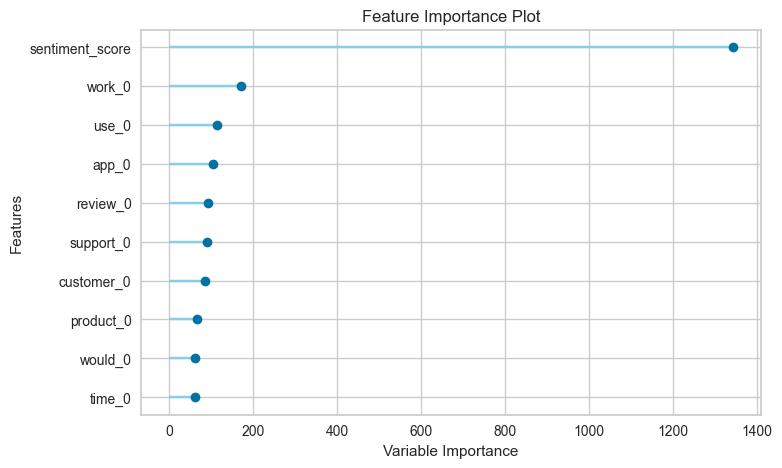

In [67]:
plot_model(tuned_gbm, plot='feature')

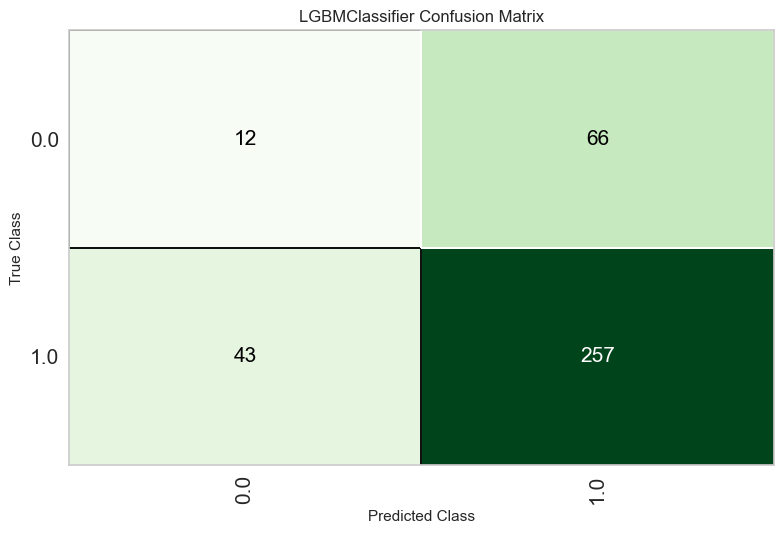

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

In [68]:
plot_model(tuned_gbm, plot = 'confusion_matrix')